In [1]:
import os, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
torch.manual_seed(42)

import numpy as np
import pandas as pd

from utilities import load_coordinates, load_dtm, load_mini_batches, plot_loss
from utilities import report_macro, report_class, compute_roc, compute_prc, plot_curves
%matplotlib inline

# Specify model hyperparameters

In [2]:
n_epochs = 500
batch_size = 64
lr = 0.001
weight_decay = 0.00001

# Specify plotting parameters

In [3]:
color = "#873434" # Color for plotting evaluation metrics and word clouds
cmap = "Reds" # Color map for plotting brain structures
prefix = "occ" # Prefix for plot file names
n_top = 15 # Number of terms (i.e., inputs) to plot per brain structure (i.e., class)
fname = "figures/style/computer-modern/cmunss.ttf" # Name of the font

# Load the data

## Brain activation coordinates

In [4]:
act_bin = load_coordinates()
n_structs = act_bin.shape[1]
print("{:12s}{}".format("Documents", act_bin.shape[0]))
print("{:12s}{}".format("Structures", n_structs))

Documents   18155
Structures  114


## Term embeddings

In [5]:
vsm = pd.read_csv("data/text/glove_gen_n100_win15_min5_iter500_190428.txt", 
                  sep = " ", index_col=0, header=0)
n_vocab = vsm.shape[0]
n_emb = vsm.shape[1]
print("{:21s}{}".format("Embedding Dimension", n_emb))
print("{:21s}{}".format("Terms", n_vocab))

Embedding Dimension  100
Terms                350543


## Document-term matrix

In [6]:
dtm_bin = load_dtm()
dtm_bin = dtm_bin[dtm_bin.columns.intersection(vsm.index)]
n_terms = dtm_bin.shape[1]
print("{:12s}{}".format("Documents", dtm_bin.shape[0]))
print("{:12s}{}".format("Terms", n_terms))

Documents   18155
Terms       1542


# Split the data

## Training and dev sets

In [7]:
splits = {}
for split in ["train", "dev"]:
    splits[split] = [int(pmid.strip()) for pmid in open("data/splits/{}.txt".format(split), "r").readlines()]

## Randomized mini-batches

In [8]:
X = dtm_bin.loc[splits["train"]].transpose().values
Y = act_bin.loc[splits["train"]].transpose().values
mini_batches = load_mini_batches(X, Y, mini_batch_size=batch_size, seed=42)

# Specify the classifier

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_terms, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.dropout1 = nn.Dropout(p=0.5),
        self.fc6 = nn.Linear(100, 100)
        self.dropout2 = nn.Dropout(p=0.5),
        self.fc7 = nn.Linear(100, 100)
        self.dropout3 = nn.Dropout(p=0.5),
        self.fc8 = nn.Linear(100, n_structs)
        
        # Xavier initialization for weights
        for fc in [self.fc1, self.fc2, self.fc3, self.fc4,
                   self.fc5, self.fc6, self.fc7, self.fc8]:
            nn.init.xavier_uniform_(fc.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.dropout(x)
        x = F.relu(self.fc6(x))
        x = F.dropout(x)
        x = F.relu(self.fc7(x))
        x = F.dropout(x)
        x = torch.sigmoid(self.fc8(x))
        return x

In [10]:
net = Net()
criterion = F.binary_cross_entropy
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

# Train the classifier

In [11]:
net_file = "models/classifier_{}.pt".format(prefix)
if not os.path.exists(net_file):
    
    running_loss = []
    for epoch in range(n_epochs):  # Loop over the dataset multiple times
        for i, data in enumerate(mini_batches):

            # Get the inputs
            inputs, labels = data
            inputs = Variable(torch.from_numpy(inputs.T).float())
            labels = Variable(torch.from_numpy(labels.T).float())

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Print running loss after each epoch
        running_loss += [loss.item()]
        if epoch % (n_epochs/20) == (n_epochs/20) - 1:
            print("Epoch {:3d} \t Loss {:6.6f}".format(epoch + 1, running_loss[-1] / 100))
    
    # Export the trained model
    torch.save(net.state_dict(), net_file)
    
    # Plot the loss
    plot_loss(prefix, running_loss, xlab="Epoch", ylab="Loss", color=color)

else:
    net.load_state_dict(torch.load(net_file))

# Evaluate the classifier

In [12]:
def report_curves(data_set, name): 
    with torch.no_grad():
        inputs, labels = data_set[0]
        inputs = Variable(torch.from_numpy(inputs.T).float())
        labels = Variable(torch.from_numpy(labels.T).float())
        pred_probs = net(inputs).float()
        fpr, tpr = compute_roc(labels, pred_probs)
        prec, rec = compute_prc(labels, pred_probs)
        plot_curves("{}_roc".format(name), fpr, tpr, diag=True, alpha=0.25,
                    color=color, xlab="1 - Specificity", ylab="Sensitivity")
        plot_curves("{}_prc".format(name), rec, prec, diag=False, alpha=0.5,
                    color=color, xlab="Recall", ylab="Precision")
        
def report_metrics(data_set):
    with torch.no_grad():
        inputs, labels = data_set[0]
        inputs = Variable(torch.from_numpy(inputs.T).float())
        labels = Variable(torch.from_numpy(labels.T).float())
        outputs = net(inputs)
        predictions = (outputs > 0.5).float() * 1
        print("-" * 50 + "\nMACRO-AVERAGED TOTAL\n" + "-" * 50)
        report_macro(labels, predictions)
        print("\n" + "-" * 50 + "\n\n")
        for i in range(n_structs):
            print("-" * 50 + "\n" + act_bin.columns[i].title().replace("_", " ") + "\n" + "-" * 50)
            report_class(labels[:,i], predictions[:,i])
            print("")

## Training set performance

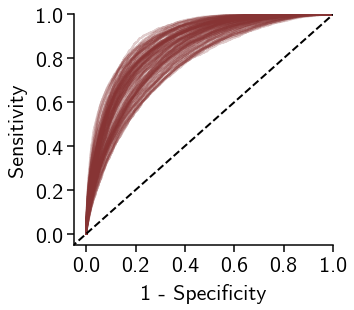

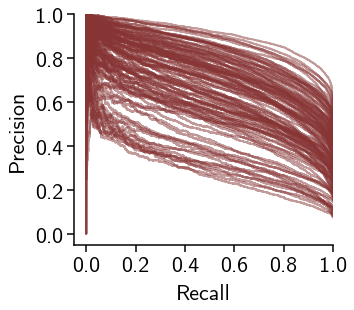

In [13]:
train_set = load_mini_batches(X, Y, mini_batch_size=len(splits["train"]), seed=42)
report_curves(train_set, "{}_train".format(prefix))

In [14]:
report_metrics(train_set)

--------------------------------------------------
MACRO-AVERAGED TOTAL
--------------------------------------------------
F1         0.5411
Precision  0.6644
Recall     0.5035
Accuracy   0.8048
ROC-AUC    0.6899

--------------------------------------------------


--------------------------------------------------
Left Frontal Pole
--------------------------------------------------
F1         0.7480
Precision  0.7149
Recall     0.7843
Accuracy   0.7225
ROC-AUC    0.7192

--------------------------------------------------
Left Insular Cortex
--------------------------------------------------
F1         0.6835
Precision  0.7079
Recall     0.6607
Accuracy   0.7711
ROC-AUC    0.7489

--------------------------------------------------
Left Superior Frontal Gyrus
--------------------------------------------------
F1         0.7357
Precision  0.7254
Recall     0.7464
Accuracy   0.7366
ROC-AUC    0.7367

--------------------------------------------------
Left Middle Frontal Gyrus
-----------

F1         0.7314
Precision  0.7064
Recall     0.7583
Accuracy   0.8058
ROC-AUC    0.7948

--------------------------------------------------
Left Frontal Operculum Cortex
--------------------------------------------------
F1         0.5717
Precision  0.6418
Recall     0.5154
Accuracy   0.7550
ROC-AUC    0.6909

--------------------------------------------------
Left Central Opercular Cortex
--------------------------------------------------
F1         0.6770
Precision  0.7222
Recall     0.6372
Accuracy   0.7865
ROC-AUC    0.7523

--------------------------------------------------
Left Parietal Operculum Cortex
--------------------------------------------------
F1         0.6623
Precision  0.7209
Recall     0.6126
Accuracy   0.8122
ROC-AUC    0.7553

--------------------------------------------------
Left Planum Polare
--------------------------------------------------
F1         0.5619
Precision  0.6648
Recall     0.4866
Accuracy   0.8446
ROC-AUC    0.7117

---------------------------

Precision  0.7816
Recall     0.8354
Accuracy   0.7909
ROC-AUC    0.7885

--------------------------------------------------
Right Lateral Occipital Cortex Inferior Division
--------------------------------------------------
F1         0.7569
Precision  0.7423
Recall     0.7719
Accuracy   0.7959
ROC-AUC    0.7923

--------------------------------------------------
Right Intracalcarine Cortex
--------------------------------------------------
F1         0.5010
Precision  0.6301
Recall     0.4159
Accuracy   0.7963
ROC-AUC    0.6681

--------------------------------------------------
Right Frontal Medial Cortex
--------------------------------------------------
F1         0.1444
Precision  0.5759
Recall     0.0826
Accuracy   0.8404
ROC-AUC    0.5354

--------------------------------------------------
Right Supplementary Motor Cortex
--------------------------------------------------
F1         0.5106
Precision  0.6548
Recall     0.4184
Accuracy   0.7677
ROC-AUC    0.6642

-----------------

## Dev set performance

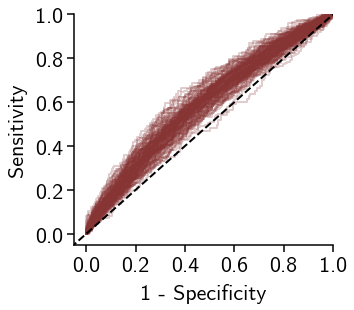

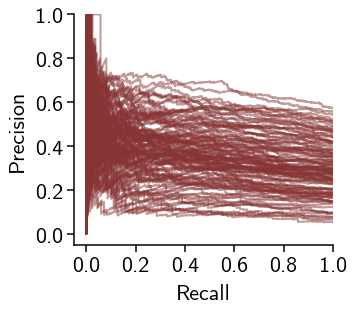

In [15]:
X_dev = dtm_bin.loc[splits["dev"]].transpose().values
Y_dev = act_bin.loc[splits["dev"]].transpose().values
dev_set = load_mini_batches(X_dev, Y_dev, mini_batch_size=len(splits["dev"]), seed=42)
report_curves(dev_set, "{}_dev".format(prefix))

In [16]:
report_metrics(dev_set)

--------------------------------------------------
MACRO-AVERAGED TOTAL
--------------------------------------------------
F1         0.2997
Precision  0.4050
Recall     0.2799
Accuracy   0.6939
ROC-AUC    0.5407

--------------------------------------------------


--------------------------------------------------
Left Frontal Pole
--------------------------------------------------
F1         0.6276
Precision  0.5619
Recall     0.7109
Accuracy   0.5727
ROC-AUC    0.5708

--------------------------------------------------
Left Insular Cortex
--------------------------------------------------
F1         0.4188
Precision  0.4527
Recall     0.3895
Accuracy   0.5903
ROC-AUC    0.5512

--------------------------------------------------
Left Superior Frontal Gyrus
--------------------------------------------------
F1         0.5905
Precision  0.5615
Recall     0.6227
Accuracy   0.5815
ROC-AUC    0.5827

--------------------------------------------------
Left Middle Frontal Gyrus
-----------

Precision  0.4301
Recall     0.4128
Accuracy   0.6278
ROC-AUC    0.5728

--------------------------------------------------
Left Frontal Operculum Cortex
--------------------------------------------------
F1         0.3420
Precision  0.3950
Recall     0.3015
Accuracy   0.6652
ROC-AUC    0.5571

--------------------------------------------------
Left Central Opercular Cortex
--------------------------------------------------
F1         0.3892
Precision  0.4316
Recall     0.3544
Accuracy   0.6509
ROC-AUC    0.5705

--------------------------------------------------
Left Parietal Operculum Cortex
--------------------------------------------------
F1         0.2894
Precision  0.3526
Recall     0.2454
Accuracy   0.6377
ROC-AUC    0.5259

--------------------------------------------------
Left Planum Polare
--------------------------------------------------
F1         0.1544
Precision  0.2500
Recall     0.1117
Accuracy   0.7467
ROC-AUC    0.5121

---------------------------------------------

Accuracy   0.6696
ROC-AUC    0.5459

--------------------------------------------------
Right Parietal Operculum Cortex
--------------------------------------------------
F1         0.2674
Precision  0.3380
Recall     0.2212
Accuracy   0.7104
ROC-AUC    0.5426

--------------------------------------------------
Right Planum Polare
--------------------------------------------------
F1         0.1515
Precision  0.2410
Recall     0.1105
Accuracy   0.7533
ROC-AUC    0.5119

--------------------------------------------------
Right Heschls Gyrus
--------------------------------------------------
F1         0.1818
Precision  0.2526
Recall     0.1420
Accuracy   0.7621
ROC-AUC    0.5230

--------------------------------------------------
Right Planum Temporale
--------------------------------------------------
F1         0.3236
Precision  0.3770
Recall     0.2835
Accuracy   0.6685
ROC-AUC    0.5508

--------------------------------------------------
Right Supracalcarine Cortex
-----------------

# Map a brain dictionary

In [17]:
from nilearn import image, plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import font_manager
from scipy.stats import zscore
from wordcloud import WordCloud
from utilities import load_atlas, mni2vox

## Compute term activation maps

Inputs are one-hot vectors representing the occurrence of each term. Outputs are probabilities for each brain structure predicted by the occurrence of a given term.

In [18]:
terms = list(dtm_bin.columns)
term_map = pd.DataFrame(index=act_bin.columns, columns=dtm_bin.columns)

In [19]:
for i, term in enumerate(terms):
    inputs = np.zeros((1, dtm_bin.shape[1]))
    inputs[0, i] = 1.0
    inputs = Variable(torch.from_numpy(inputs).float())
    pred_probs = net(inputs).float().detach().numpy()
    term_map[term] = pred_probs[0,:]

## Load coordinates for brain structures

In [20]:
c = pd.read_csv("data/brain/labels.csv", index_col=None, header=0)
struct2coord = {}
for struct, x, y, z in zip(c["PREPROCESSED"], c["X"], c["Y"], c["Z"]):
    struct2coord[struct] = mni2vox(x, y, z)

## Plot brain maps and word clouds

In [21]:
verbose = False
for i, struct in enumerate(act_bin.columns):
    struct = act_bin.columns[i]
    outfile = "figures/maps/{}/{}.png".format(prefix, struct)
    
    if not os.path.exists(outfile):
        x, y, z = struct2coord[struct]
        if verbose:
            print("{} (z={})".format(struct.title().replace("_", " "), int(z)))
        if not verbose:
            plt.ioff()

        fig, ax = plt.subplots(1,2, figsize=(6,6))
        gs1 = gridspec.GridSpec(1,2)
        gs1.update(wspace=-20, hspace=-10)
        fig.suptitle(c["PRESENTABLE_TITLE"][i], y=0.79,
                     fontproperties=font_manager.FontProperties(fname=fname, size=24))

        bg_img = image.load_img("data/brain/atlases/MNI152_T1_1mm_brain.nii.gz")
        bg_img = np.flip(np.rot90(bg_img.get_data()[:,:,int(z)]).astype(float), axis=1)
        bg_img[bg_img == 0] = np.nan
        bg_img = bg_img[10:198, 20:162]

        bilateral_atlas = load_atlas()
        struct_img = np.flip(np.rot90(bilateral_atlas.get_data()[:,:,int(z)]), axis=1)
        struct_img[struct_img != i+1] = np.nan
        struct_img[struct_img == i+1] = 1.0
        struct_img[struct_img == 0] = np.nan
        struct_img = struct_img[10:198, 20:162]
    
        ax[0].imshow(bg_img, cmap="Greys_r", alpha=0.7, vmin=1)
        ax[0].imshow(struct_img, cmap=cmap, alpha=0.6, vmin=0, vmax=1)
        for side in ["left", "right", "top", "bottom"]:
            ax[0].spines[side].set_visible(False)
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        def color_func(word, font_size, position, orientation, 
                   random_state=None, idx=0, **kwargs):
            return color

        top = term_map.loc[struct].sort_values(ascending=False)[:n_top]
        vals = top.values
        tkns = [t.replace("_", " ") for t in top.index]
        cloud = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGB", 
                          max_font_size=180, min_font_size=10, 
                          prefer_horizontal=1, scale=20, margin=3,
                          width=1200, height=1400, font_path=fname, 
                          random_state=42).generate_from_frequencies(zip(tkns, vals))
        ax[1].imshow(cloud.recolor(color_func=color_func, random_state=42))
        ax[1].axis("off")

        plt.savefig(outfile, bbox_inches="tight", dpi=250)
        if verbose:
            plt.show()
        plt.close()

## Combine into one figure

In [22]:
import os
from PIL import Image, ImageOps

In [23]:
images = ["figures/maps/{}/{}.png".format(prefix, struct) for struct in act_bin.columns]
img_w, img_h = Image.open(images[0]).size

In [24]:
pad_w, pad_h = 60, 30
img_w += pad_w * 2
img_h += pad_h * 2
n_row, n_col = 19, 6
fig_w = n_col * img_w
fig_h = n_row * img_h
x_coords = list(range(0, fig_w, img_w)) * n_row
y_coords = np.repeat(list(range(0, fig_h, img_h)), n_col)
padding = (pad_w, pad_h, pad_w, pad_h)
white = (255,255,255,0)

In [25]:
figure = Image.new("RGB", (fig_w, fig_h), color=white)
for i, img in enumerate(images):
    img = Image.open(img)
    img = ImageOps.expand(img, padding, fill=white)
    figure.paste(img, (x_coords[i], y_coords[i]))
figure.save("figures/maps/{}_map.png".format(prefix))
figure